In [2]:
# Imports
# 
# Note: these are all the imports you need for this assignment!
# Do not import any other functions / packages

# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import shapely

#need to pip install
import altair as alt
import geopandas as gpd

alt.renderers.enable('notebook')

# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

# Things to do:
    - Vega popup graphs
    - Time based evolution
    - Marker cluster
    - Count points in location
    - subgroups and groups
    - Make vega graphs on layers to switch between different datapoints
    - Make vega time evolution graphs
    - Integrate ipywidgets

# Open Map Files

In [3]:
saveCrimeMap = r'CrimeMap.html'
saveArrestMap = r'ArrestMap.html'

# Import Datasets

In [4]:
lapd_districts = gpd.read_file('LA_Data/LAPD_Reporting_Districts.geojson')
lapd_districts

,OBJECTID,REPDIST,PREC,APREC,...,PERIMETER,Shape__Area,Shape__Length,geometry
0,1001,508,5,HARBOR,...,13489.08,8.99e+06,13489.08,"POLYGON ((-118.30892 33.81705, -118.30892 33.8..."
1,1002,509,5,HARBOR,...,15408.61,1.21e+07,15408.61,"POLYGON ((-118.30836 33.80899, -118.30892 33.8..."
2,1003,518,5,HARBOR,...,16626.31,1.05e+07,16626.31,"POLYGON ((-118.25681 33.79953, -118.25682 33.7..."
...,...,...,...,...,...,...,...,...,...
1132,998,506,5,HARBOR,...,13918.01,1.17e+07,13918.01,"POLYGON ((-118.30909 33.83724, -118.30909 33.8..."
1133,999,519,5,HARBOR,...,56458.38,4.47e+07,56458.38,"POLYGON ((-118.25681 33.79953, -118.25654 33.7..."
1134,1000,507,5,HARBOR,...,14308.10,1.14e+07,14308.10,"POLYGON ((-118.30900 33.82564, -118.30899 33.8..."


In [5]:
crime_data = pd.read_csv('LA_Data/Crime_Data_from_2010_to_Present.csv')

In [6]:
arrest_data = pd.read_csv('LA_Data/Arrest_Data_from_2010_to_Present.csv')

# Drop Data We Won't Use

In [7]:
crime_data = crime_data[['DR_NO','Date Rptd','DATE OCC','TIME OCC',
                         'AREA NAME','Rpt Dist No','Crm Cd Desc',
                         'Vict Age','Vict Sex','Vict Descent','LOCATION']]

In [8]:
arrest_data = arrest_data[['Report ID', 'Arrest Date', 'Time',
                           'Area Name', 'Reporting District', 'Age',
                           'Sex Code', 'Descent Code', 'Charge Description','Location']]

# Clean Remaining Data

In [9]:
crime_data = crime_data.dropna(subset = ['Rpt Dist No'])
arrest_data = arrest_data.dropna(subset = ['Reporting District'])

# Separate Out Values to Map and Graph

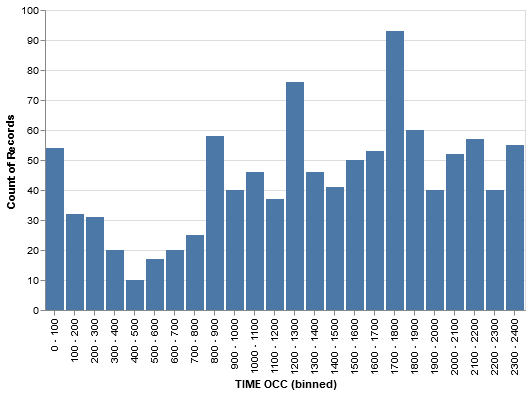

In [19]:
graph_frame = crime_data.where(crime_data['Rpt Dist No'] == 519).dropna()
chart = alt.Chart(graph_frame).mark_bar(
    ).encode(
        alt.X('Vict Age:O',bin=alt.Bin(maxbins=25)),
        y = 'count(Vict Age):Q',color = 'Vict Sex'
    )
desc_chart = alt.Chart(
    graph_frame
    ).transform_aggregate(
        count = 'count()',
        groupby = ['Crm Cd Desc']
    ).transform_window(
        rank='rank(count)',
        sort=[alt.SortField('count', order='descending')]
    ).mark_bar().encode(
        x = alt.X('Crm Cd Desc:O',
                sort=alt.EncodingSortField(field='count',
                                           op='sum',
                                           order='descending')),
        y = alt.Y('count:Q')
    ).transform_filter(
        alt.datum.rank < 25
    )
time_chart = alt.Chart(graph_frame
    ).mark_bar().encode(
        alt.X('TIME OCC:O',bin = alt.Bin(maxbins = 25)),
        y = 'count(TIME OCC):Q'
    )
time_chart

In [36]:
lacrimemap = folium.Map([34.0440386,-118.249058])
folium.Marker(
    location=[34.044,-118.249],
    popup = folium.Popup(max_width = 550).add_child(
        folium.VegaLite(chart,width = 550, height = 250))
             ).add_to(lacrimemap)
lacrimemap

In [21]:
for i in range(len(lapd_districts)):
    graph_frame = crime_data.where(crime_data['Rpt Dist No'] == REPDIST[i]).dropna()
    

,DR_NO,Date Rptd,DATE OCC,TIME OCC,...,Vict Age,Vict Sex,Vict Descent,LOCATION
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,...,48,M,H,300 E GAGE AV
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,...,0,M,W,SEPULVEDA BL
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,...,0,M,H,1300 E 21ST ST
...,...,...,...,...,...,...,...,...,...
2070683,192004409,01/06/2019 12:00:00 AM,01/06/2019 12:00:00 AM,2100,...,46,F,B,6TH
2070684,191716777,10/17/2019 12:00:00 AM,10/16/2019 12:00:00 AM,1800,...,0,NaN,NaN,17200 NAPA ST
2070685,190805435,02/01/2019 12:00:00 AM,02/01/2019 12:00:00 AM,1615,...,33,F,W,1700 BARRY AV


# Create Map and Graphs

In [ ]:
lacrimemap = folium.Map([34.0440386,-118.249058])
laarrestmap = folium.Map([34.0440386,-118.249058])

# Save Map Externally